In [26]:
import sys
import os
import networkx as nx
from sympy import *
from bond_graph import *
# from bond_graph_nodes import *
from scipy import *
import time
import matplotlib.pyplot as plt
%reload_ext autoreload
%autoreload 2


In [27]:
t_span = [0, 5]
t = np.linspace(t_span[0], t_span[1], 500)

m_b = 1794.0
I = 3443.05
m_wf = 87.15
m_wr = 140.04

k_tf = 155900.0
k_tr = 200000.0

b1 = 1.271
b2 = 1.713

### Nominal
C_sf = 1190
C_sr = 1000
k_sf = 66824
k_sr = 18615

### Optimal 
# C_sf = 2497.9
# C_sr = 2494.5
# k_sf = 28949.4
# k_sr = 11115.7

### DQN
C_sf = 2248
C_sr = 1684
k_sf = 11990
k_sr = 11025

### Ranges
C_sf_min = 1000
C_sr_min = 1000
k_sf_min = 10000
k_sr_min = 10000 

C_sf_max = 2500
C_sr_max = 2500
k_sf_max = 70000
k_sr_max = 70000


### Simulate Dynamics

In [28]:
def speed_bump_excitation(t):
    H = 0.075
    L = 0.5
    KPH_to_MPS = 1.0/3.6
    v = 10 * KPH_to_MPS

    if t >= 0:
        # y1 = -(H/2)*(np.cos(2*np.pi*v*t/L)-1), 
        # return (np.pi*H*v/L)*(np.sin(2*np.pi*v*t/L))
        # return 0.0
        y1 = 0.1
    else:
        y1 = 0.0
    
    # if t >= v/(b1+b2):
    if t >= 0.1:
        y2 = 0.1
    else:
        y2 = 0.0

    return np.array([y1, y2])



### Speed Bump Forcing Function

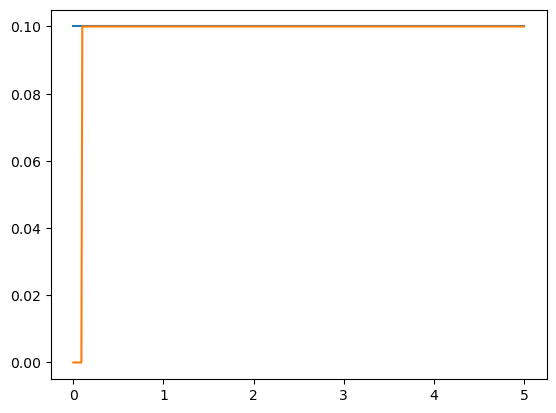

In [29]:
u = np.array(list(speed_bump_excitation(t_i) for t_i in t))
# print(u)
plt.plot(t,u[:,0])
plt.plot(t, u[:,1])
plt.show()

### Solve ODE

In [30]:

# x0 = np.zeros(len(G.get_energy_storage_elements())) # Initial conditions
x0 = np.zeros(8)
# print(len(np.array([0, 0])))
# u = lambda t: [0]
# G.dynamics(x0 , 1, u)

## Generate a forcing input at 5 hertz
u = lambda t: speed_bump_excitation(t)
# u = lambda t: 0


def half_car_dynamics(z, t, u):
    xf = z[0]
    xf_dot = z[1]
    xr = z[2]
    xr_dot = z[3]
    phi = z[4]
    phi_dot = z[5]
    xb = z[6]
    xb_dot = z[7]
    
    xf_ddot = (1/m_wf)*(-C_sf*(xf_dot+b1*phi_dot-xb_dot) - k_sf*(xf+b1*phi-xb) - k_tf*xf + k_tf*u(t)[0])
    xr_ddot = (1/m_wr)*(-C_sr*(xr_dot+b2*phi_dot-xb_dot) - k_sr*(xr-b2*phi-xb) - k_tr*xr + k_tr*u(t)[1])
    phi_ddot = (1/I)*(-C_sf*b1*(b1*phi_dot+xf_dot-xb_dot) - C_sr*b2*(b2*phi_dot-xr_dot+xb_dot) - k_sf*b1*(b1*phi+xf-xb) - k_sr*b2*(b2*phi-xr+xb))
    xb_ddot = (1/m_b)*(-C_sf*(xb_dot-b1*phi_dot-xf_dot) - C_sr*(xb_dot+b2*phi_dot-xr_dot) - k_sf*(xb-b1*phi-xf) - k_sr*(xb+b2*phi-xr))
    
    return[xf_dot, xf_ddot, xr_dot, xr_ddot, phi_dot, phi_ddot, xb_dot, xb_ddot]

z = integrate.odeint(half_car_dynamics, np.array(x0), t, args=(u,))







### Plots

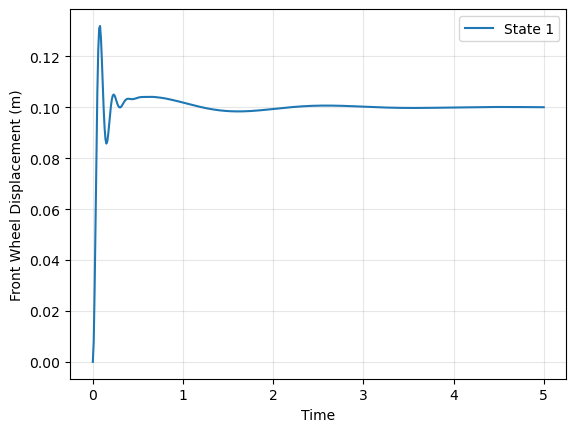

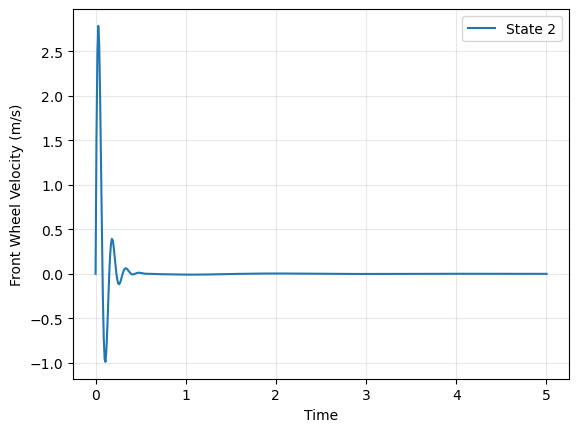

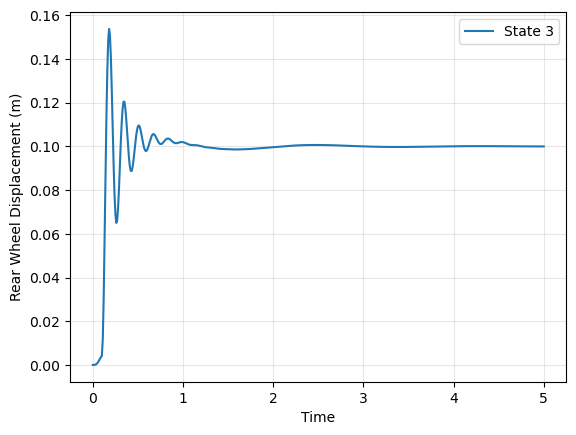

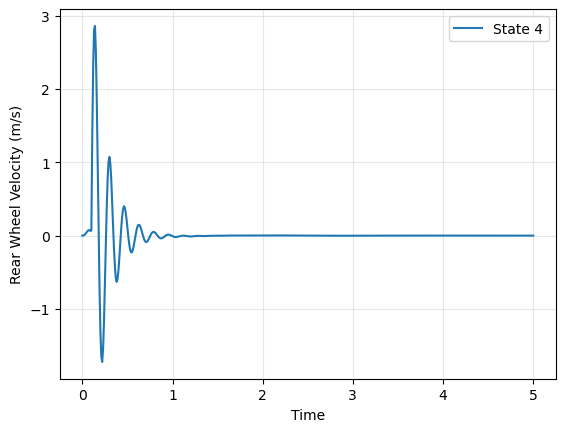

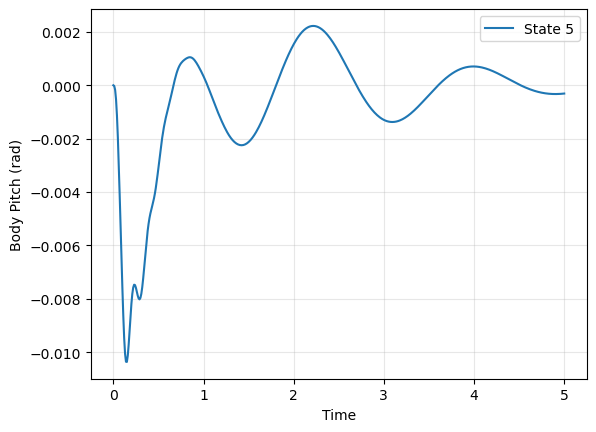

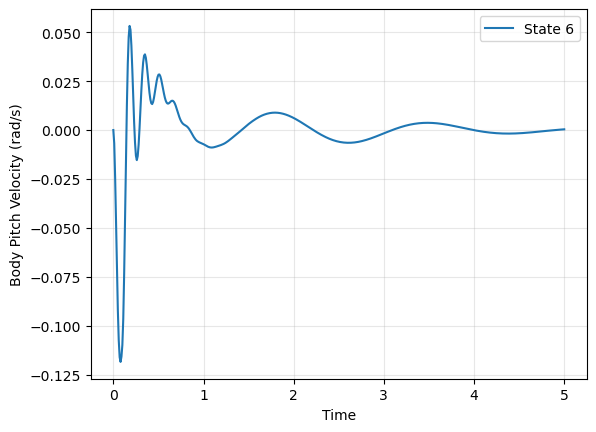

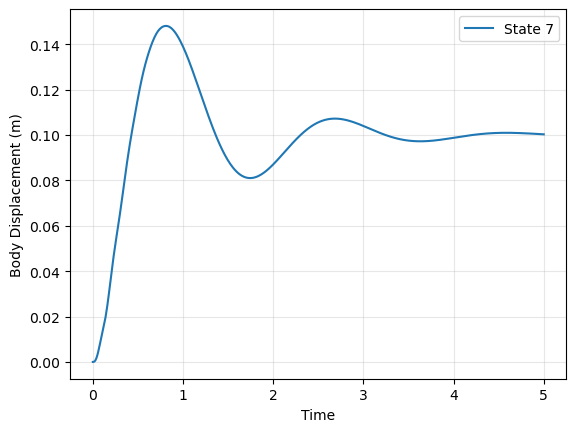

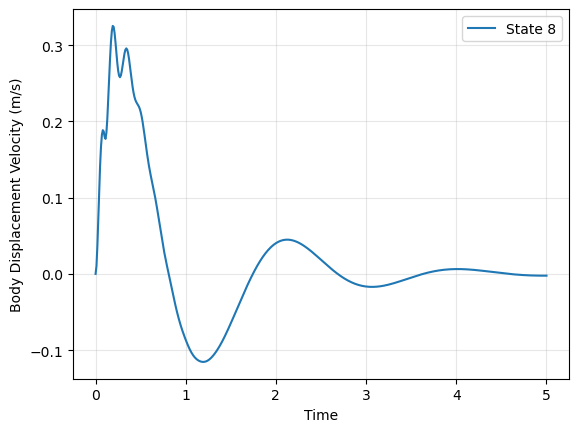

In [31]:
import matplotlib.pyplot as plt

# Assuming `z` is the array containing the time series data
var_names = ["Front Wheel Displacement (m)", "Front Wheel Velocity (m/s)", "Rear Wheel Displacement (m)", "Rear Wheel Velocity (m/s)", "Body Pitch (rad)", "Body Pitch Velocity (rad/s)", "Body Displacement (m)", "Body Displacement Velocity (m/s)"]
# Plot the first 4 time series
for i in range(8):
    plt.plot(t, z[:,i], label=f"State {i+1}")
    plt.xlabel("Time")
    plt.ylabel(var_names[i])
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()
        



### Cost Function Computation

In [32]:
dt = t[1] - t[0]

xf = z[:, 0]
xf_dot = z[:, 1]
xr = z[:, 2]
xr_dot = z[:, 3]
phi = z[:, 4]
phi_dot = z[:, 5]
xb = z[:, 6]
xb_dot = z[:, 7]


## J1: Peak accel of vehicle body
xb_ddot = np.gradient(xb_dot, dt) 
phi_ddot = np.gradient(phi_dot, dt)

J1 = np.linalg.norm(xb_ddot, np.inf) + np.linalg.norm(phi_ddot, np.inf)
print("J1: ", J1)

## J2: Peak dynamic load
u = np.array([speed_bump_excitation(t_i) for t_i in t])

# print(u[:,0].shape)
# print(xf.shape)
J2 = np.linalg.norm(k_tf*(xf - u[:, 0]), np.inf) + np.linalg.norm(k_tr*(xr - u[:, 1]), np.inf)
print("J2: ", J2)

## J3: Suspension working space peak val
J3 = max(xb - xf) + max(xb - xr)
print("J3: ", J3)

## J4: Settling time
crossing_times = [t[i] for i in range(len(xb)) if abs(xb[i]) >= 0.0001]
last_crossing_time = crossing_times[-1] if crossing_times else None
# print(last_crossing_time)
J4 = last_crossing_time
print("J4: ", J4)

# ## Weights
w1 = 100
w2 = 100
w3 = 100
w4 = 50

J = [J1, J2, J3, J4]
w = [w1, w2, w3, w4]

# # print("J:", J)

J_lower = [3.844, 2293.4, 0.1531, 5.9042]
J_upper = [10.518, 31772, 0.2343, 8]

# # J_overall = J_lower + J_upper
J_overall = 0

for i in range(len(J)):
    J_overall += abs(w[i] * (J[i] - J_lower[i])/(J_upper[i] - J_lower[i]))
    print(w[i] * (J[i] - J_lower[i])/(J_upper[i] - J_lower[i]))
    # J_overall += w[i] * (J[i] - J_lower[i])/(J_upper[i] - )
    

print("J Overall: ", J_overall)


J1:  6.527637594372008
J2:  34765.37698303595
J3:  0.0910927016733638
J4:  5.0
40.210332549775366
110.15440686815505
-76.3636678899461
-21.571714858288015
J Overall:  248.30012216616453


### Save to file

In [33]:
# import pickle

# t_span = [0, 5.0]
# t = np.linspace(t_span[0], t_span[1], 500)
# # Create a dictionary to store the variables
# data = {
#     't': t,
#     'z': z
# }

# # Specify the file path
# file_path = 'data/half_car_nom.pkl'

# # Save the data to the file
# with open(file_path, 'wb') as file:
#     pickle.dump(data, file)